In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import re
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.sparse import hstack, csr_matrix
import scipy.cluster.hierarchy as shc
import warnings

warnings.filterwarnings('ignore')

In [2]:
# --- Configuration ---
DATA_FILE = 'scaler_clustering.csv'
CURRENT_YEAR = datetime.now().year
KNN_IMPUTE_NEIGHBORS = 5
SAMPLE_SIZE = 5000 # Sample size for hierarchical clustering efficiency
OPTIMAL_K = 5 # Placeholder K for K-Means (Review elbow plot after first run)
MIN_GROUP_SIZE_FOR_RANKING = 10 # Min employees in a group for reliable Top N ranking
MAX_YEARS_EXPERIENCE = 60 # Cap for years of experience
MIN_VALID_YEAR = 1960 # Min valid year for 'orgyear'

In [3]:
# --- 1. Load Data ---
print(f"--- 1. Loading Data from {DATA_FILE} ---")
try:
    # Specify low_memory=False to potentially avoid dtype mixing warnings on large files
    df = pd.read_csv(DATA_FILE, low_memory=False)
    print("Data loaded successfully.")
    print(f"Shape of the dataset: {df.shape}")
except FileNotFoundError:
    print(f"Error: File not found at {DATA_FILE}")
    exit()
except Exception as e:
    print(f"Error loading data: {e}")
    exit()

--- 1. Loading Data from scaler_clustering.csv ---
Data loaded successfully.
Shape of the dataset: (205843, 7)


In [4]:
# --- 2. Initial Exploratory Data Analysis (EDA) ---
print("\n--- 2. Initial Exploratory Data Analysis ---")
print("\nDataset Info:")
df.info()

print("\nFirst 5 rows:")
print(df.head())

print("\nStatistical Summary (Numerical):")
# Note: Extremely high max 'ctc' suggests potential outliers. Consider handling (e.g., capping, log transform) in future analysis.
# Note: Min/Max 'orgyear' outside expected range indicates data quality issues. Will be handled in preprocessing.
print(df.describe())

print("\nStatistical Summary (Categorical):")
print(df.describe(include='object'))

# Check unique emails
print(f"\nTotal rows: {len(df)}")
print(f"Unique email_hash count: {df['email_hash'].nunique()}")
email_counts = df['email_hash'].value_counts()
print(f"Emails appearing more than once: {sum(email_counts > 1)}")
print("Top 5 most frequent email_hash:")
print(email_counts.head())

# Check unique company_hash before cleaning
print(f"\nUnique company_hash count (before cleaning): {df['company_hash'].nunique()}")
print("Top 5 company_hash values (before cleaning):")
print(df['company_hash'].value_counts().head())

# Check unique job_position before cleaning
print(f"\nUnique job_position count (before cleaning): {df['job_position'].nunique()}")
print("Top 5 job_position values (before cleaning):")
print(df['job_position'].value_counts().head())


--- 2. Initial Exploratory Data Analysis ---

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205843 entries, 0 to 205842
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        205843 non-null  int64  
 1   company_hash      205799 non-null  object 
 2   email_hash        205843 non-null  object 
 3   orgyear           205757 non-null  float64
 4   ctc               205843 non-null  int64  
 5   job_position      153279 non-null  object 
 6   ctc_updated_year  205843 non-null  float64
dtypes: float64(2), int64(2), object(3)
memory usage: 11.0+ MB

First 5 rows:
   Unnamed: 0               company_hash  \
0           0             atrgxnnt xzaxv   
1           1  qtrxvzwt xzegwgbb rxbxnta   
2           2              ojzwnvwnxw vx   
3           3                  ngpgutaxv   
4           4                 qxen sqghu   

                                          email_hash  

In [5]:
# --- 3. Data Pre-processing ---
print("\n--- 3. Data Pre-processing ---")

# Drop the 'Unnamed: 0' column if it exists and is just an index
if 'Unnamed: 0' in df.columns:
    print("\nDropping 'Unnamed: 0' column.")
    df.drop('Unnamed: 0', axis=1, inplace=True)

# Handle Missing Values & Clean Text Columns
print("\nChecking for missing values:")
print(df.isnull().sum())

print("\nCleaning 'company_hash' and 'job_position'...")
df['company_hash'].fillna('Unknown_Company', inplace=True)
df['job_position'].fillna('Unknown_Position', inplace=True)

def clean_text(text):
    if isinstance(text, str):
        text = re.sub(r'[^\w\s]', '', text) # Keep alphanumeric and whitespace
        text = text.strip().lower()
        text = re.sub(r'\s+', ' ', text) # Consolidate whitespace
    return text

df['Company_hash_Cleaned'] = df['company_hash'].apply(clean_text)
df['Job_position_Cleaned'] = df['job_position'].apply(clean_text)
# Replace potentially empty strings after cleaning
df['Company_hash_Cleaned'].replace('', 'unknown_company', inplace=True)
df['Job_position_Cleaned'].replace('', 'unknown_position', inplace=True)

print(f"\nUnique Company_hash count (after cleaning): {df['Company_hash_Cleaned'].nunique()}")
print(f"Unique Job_position count (after cleaning): {df['Job_position_Cleaned'].nunique()}")

# Handle Data Types and Impute 'orgyear'
print("\nProcessing numerical columns and imputing 'orgyear'...")
df['ctc'] = pd.to_numeric(df['ctc'], errors='coerce')
df['ctc_updated_year'] = pd.to_numeric(df['ctc_updated_year'], errors='coerce')
df['orgyear'] = pd.to_numeric(df['orgyear'], errors='coerce')

# --- Handle invalid 'orgyear' values before imputation ---
# Set years outside a reasonable range (e.g., 1960-CurrentYear) to NaN
df.loc[(df['orgyear'] < MIN_VALID_YEAR) | (df['orgyear'] > CURRENT_YEAR), 'orgyear'] = np.nan
print(f"\nSet 'orgyear' outside {MIN_VALID_YEAR}-{CURRENT_YEAR} to NaN.")

print("\nMissing values before imputation (ctc, orgyear):")
print(df[['ctc', 'orgyear']].isnull().sum())

# Impute ctc first if needed (median)
if df['ctc'].isnull().any():
    print("\nImputing missing ctc values using median...")
    # Note: Imputing CTC outliers with median might still leave skewed distribution. Consider capping or log transform for future analysis.
    median_imputer_ctc = SimpleImputer(strategy='median')
    df['ctc'] = median_imputer_ctc.fit_transform(df[['ctc']])
    print("ctc imputation done.")

# Impute orgyear using KNN based on ctc
if df['orgyear'].isnull().any():
    print(f"\nImputing missing 'orgyear' values using KNNImputer (k={KNN_IMPUTE_NEIGHBORS})...")
    impute_features = ['ctc', 'orgyear']
    df_impute = df[impute_features].copy()
    # Scale before KNN
    scaler_impute = StandardScaler()
    df_impute_scaled = scaler_impute.fit_transform(df_impute)
    # KNN Imputation
    knn_imputer = KNNImputer(n_neighbors=KNN_IMPUTE_NEIGHBORS)
    df_impute_imputed_scaled = knn_imputer.fit_transform(df_impute_scaled)
    # Inverse scale
    df_impute_imputed = scaler_impute.inverse_transform(df_impute_imputed_scaled)
    # Update orgyear, ensuring it's integer
    df['orgyear'] = df_impute_imputed[:, impute_features.index('orgyear')].round().astype(int)
    print("orgyear imputation done.")
else:
    print("\nNo missing 'orgyear' values to impute after initial cleaning.")

# Ensure orgyear is integer type after potential imputation
df['orgyear'] = df['orgyear'].astype(int)

print("\nMissing values after imputation (ctc, orgyear):")
print(df[['ctc', 'orgyear']].isnull().sum()) # Should be 0

# Remove Duplicates (based on all columns)
print("\nChecking for duplicate rows...")
initial_rows = len(df)
# Consider which columns define a true duplicate. Using all columns for now.
df.drop_duplicates(inplace=True)
final_rows = len(df)
print(f"Removed {initial_rows - final_rows} duplicate rows.")
print(f"Shape after dropping duplicates: {df.shape}")

# Feature Engineering: Years of Experience
print("\nCreating 'Years_of_Experience' feature...")
df['Years_of_Experience'] = CURRENT_YEAR - df['orgyear']
# Cap experience to handle potential remaining issues from imputation or original data
df['Years_of_Experience'] = df['Years_of_Experience'].apply(lambda x: min(max(0, x), MAX_YEARS_EXPERIENCE))
print(f"Capped 'Years_of_Experience' at {MAX_YEARS_EXPERIENCE} years.")
print(df[['orgyear', 'Years_of_Experience']].head())
print("\nYears_of_Experience summary (after capping):")
print(df['Years_of_Experience'].describe())


--- 3. Data Pre-processing ---

Dropping 'Unnamed: 0' column.

Checking for missing values:
company_hash           44
email_hash              0
orgyear                86
ctc                     0
job_position        52564
ctc_updated_year        0
dtype: int64

Cleaning 'company_hash' and 'job_position'...

Unique Company_hash count (after cleaning): 37228
Unique Job_position count (after cleaning): 885

Processing numerical columns and imputing 'orgyear'...

Set 'orgyear' outside 1960-2025 to NaN.

Missing values before imputation (ctc, orgyear):
ctc          0
orgyear    160
dtype: int64

Imputing missing 'orgyear' values using KNNImputer (k=5)...
orgyear imputation done.

Missing values after imputation (ctc, orgyear):
ctc        0
orgyear    0
dtype: int64

Checking for duplicate rows...
Removed 34 duplicate rows.
Shape after dropping duplicates: (205809, 8)

Creating 'Years_of_Experience' feature...
Capped 'Years_of_Experience' at 60 years.
   orgyear  Years_of_Experience
0     2

In [6]:
# --- 4. Further EDA (Post Pre-processing) ---
print("\n--- 4. Further EDA (Post Pre-processing) ---")
# Plotting distributions and relationships
numerical_cols = ['ctc', 'Years_of_Experience', 'ctc_updated_year']
print("\nGenerating distribution plots...")
for col in numerical_cols:
    try:
        plt.figure(figsize=(10, 4))
        # Use log scale for CTC as it's highly skewed
        if col == 'ctc':
            # Filter out non-positive values for log scale if any exist after cleaning
            plot_data = df[df[col] > 0][col].dropna()
            if not plot_data.empty:
                sns.histplot(plot_data, kde=True, log_scale=True)
                plt.title(f'Distribution of {col} (Log Scale)')
            else:
                plt.title(f'Distribution of {col} (No positive data for log scale)')
        else:
            plot_data = df[col].dropna()
            if not plot_data.empty:
                sns.histplot(plot_data, kde=True)
                plt.title(f'Distribution of {col}')
            else:
                 plt.title(f'Distribution of {col} (No data)')
        plt.tight_layout()
        plt.savefig(f'dist_{col}.png')
        plt.close()
        print(f"Saved distribution plot for {col} as dist_{col}.png")
    except Exception as e:
        print(f"Could not generate distribution plot for {col}: {e}")

categorical_cols = ['Company_hash_Cleaned', 'Job_position_Cleaned']
print("\nGenerating count plots for top N categorical features...")
N_TOP = 20
for col in categorical_cols:
    try:
        plt.figure(figsize=(12, 6))
        # Ensure the column exists and has data
        if col in df.columns and not df[col].empty:
            top_categories = df[col].value_counts().nlargest(N_TOP).index
            if not top_categories.empty:
                sns.countplot(y=df[df[col].isin(top_categories)][col], order=top_categories)
                plt.title(f'Top {N_TOP} Categories in {col}')
            else:
                plt.title(f'No top categories found for {col}')
        else:
            plt.title(f'Column {col} not found or empty')
        plt.tight_layout()
        plt.savefig(f'count_{col}.png')
        plt.close()
        print(f"Saved count plot for {col} as count_{col}.png")
    except Exception as e:
        print(f"Could not generate count plot for {col}: {e}")

print("\nGenerating Bivariate Analysis (Experience vs ctc)...")
try:
    plt.figure(figsize=(10, 6))
    # Sample data for scatter plot if too large
    sample_df_scatter = df.sample(n=min(50000, len(df)), random_state=42) if len(df) > 50000 else df
    # Filter out non-positive CTC for log scale
    plot_data_scatter = sample_df_scatter[sample_df_scatter['ctc'] > 0]
    if not plot_data_scatter.empty:
        sns.scatterplot(data=plot_data_scatter, x='Years_of_Experience', y='ctc', alpha=0.3)
        plt.yscale('log') # Apply log scale to y-axis
        plt.title('Years of Experience vs ctc (Sampled, Log Scale)')
    else:
        plt.title('Years of Experience vs ctc (No positive ctc data for log scale)')
    plt.tight_layout()
    plt.savefig('bivariate_exp_ctc.png')
    plt.close()
    print("Saved scatter plot for Experience vs ctc as bivariate_exp_ctc.png")
except Exception as e:
    print(f"Could not generate scatter plot: {e}")


--- 4. Further EDA (Post Pre-processing) ---

Generating distribution plots...
Saved distribution plot for ctc as dist_ctc.png
Saved distribution plot for Years_of_Experience as dist_Years_of_Experience.png
Saved distribution plot for ctc_updated_year as dist_ctc_updated_year.png

Generating count plots for top N categorical features...
Saved count plot for Company_hash_Cleaned as count_Company_hash_Cleaned.png
Saved count plot for Job_position_Cleaned as count_Job_position_Cleaned.png

Generating Bivariate Analysis (Experience vs ctc)...
Saved scatter plot for Experience vs ctc as bivariate_exp_ctc.png


In [7]:
# --- 5. Manual Clustering ---
print("\n--- 5. Manual Clustering ---")
print("\nCalculating ctc summaries...")
# Calculate summaries (mean, median, etc.)
summary_co_job_exp = df.groupby(['Company_hash_Cleaned', 'Job_position_Cleaned', 'Years_of_Experience'])['ctc'].agg(['mean', 'median', 'max', 'min', 'count']).reset_index()
summary_co_job_exp.rename(columns={'mean': 'Avg_ctc_Co_Job_Exp', 'median': 'Median_ctc_Co_Job_Exp', 'max': 'Max_ctc_Co_Job_Exp', 'min': 'Min_ctc_Co_Job_Exp', 'count': 'Count_Co_Job_Exp'}, inplace=True)
summary_co_job = df.groupby(['Company_hash_Cleaned', 'Job_position_Cleaned'])['ctc'].agg(['mean', 'median', 'max', 'min', 'count']).reset_index()
summary_co_job.rename(columns={'mean': 'Avg_ctc_Co_Job', 'median': 'Median_ctc_Co_Job', 'max': 'Max_ctc_Co_Job', 'min': 'Min_ctc_Co_Job', 'count': 'Count_Co_Job'}, inplace=True)
summary_co = df.groupby(['Company_hash_Cleaned'])['ctc'].agg(['mean', 'median', 'max', 'min', 'count']).reset_index()
summary_co.rename(columns={'mean': 'Avg_ctc_Co', 'median': 'Median_ctc_Co', 'max': 'Max_ctc_Co', 'min': 'Min_ctc_Co', 'count': 'Count_Co'}, inplace=True)

print("\nMerging summaries with the main dataframe...")
df = pd.merge(df, summary_co_job_exp, on=['Company_hash_Cleaned', 'Job_position_Cleaned', 'Years_of_Experience'], how='left')
df = pd.merge(df, summary_co_job, on=['Company_hash_Cleaned', 'Job_position_Cleaned'], how='left')
df = pd.merge(df, summary_co, on=['Company_hash_Cleaned'], how='left')
print("Merging complete.")

# Create Flags (Designation, Class, Tier)
print("\nCreating manual clustering flags...")
# Ensure comparison columns are numeric before creating flags
for col in ['ctc', 'Avg_ctc_Co_Job_Exp', 'Avg_ctc_Co_Job', 'Avg_ctc_Co']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df['Designation'] = np.select([df['ctc'] > df['Avg_ctc_Co_Job_Exp'], df['ctc'] == df['Avg_ctc_Co_Job_Exp']], [1, 2], default=3)
df['Designation'] = df['Designation'].where(df['Avg_ctc_Co_Job_Exp'].notna() & df['ctc'].notna(), other=2) # Handle NaN averages or ctc
df['Class'] = np.select([df['ctc'] > df['Avg_ctc_Co_Job'], df['ctc'] == df['Avg_ctc_Co_Job']], [1, 2], default=3)
df['Class'] = df['Class'].where(df['Avg_ctc_Co_Job'].notna() & df['ctc'].notna(), other=2)
df['Tier'] = np.select([df['ctc'] > df['Avg_ctc_Co'], df['ctc'] == df['Avg_ctc_Co']], [1, 2], default=3)
df['Tier'] = df['Tier'].where(df['Avg_ctc_Co'].notna() & df['ctc'].notna(), other=2)
print("Flags created (Designation, Class, Tier).")
print(df[['Designation', 'Class', 'Tier']].value_counts())



--- 5. Manual Clustering ---

Calculating ctc summaries...

Merging summaries with the main dataframe...
Merging complete.

Creating manual clustering flags...
Flags created (Designation, Class, Tier).
Designation  Class  Tier
3            3      3       63426
2            2      2       33069
             3      3       18558
1            1      1       16855
             3      3       16074
2            2      3       12948
             1      1       12137
             2      1        9521
1            1      3        7942
2            1      3        5571
3            1      1        2545
                    3        2366
2            3      1        2104
3            3      1        1311
1            3      1        1293
3            2      3          22
1            2      3          18
                    1          16
3            2      1          11
2            1      2          10
             3      2           7
1            1      2           2
3            1      2   

In [8]:
# --- 6. Answering Questions based on Manual Clustering ---
print("\n--- 6. Answering Questions based on Manual Clustering ---")
df_results = df[['email_hash', 'Company_hash_Cleaned', 'Job_position_Cleaned', 'Years_of_Experience', 'ctc', 'Designation', 'Class', 'Tier']].copy()
df_results.sort_values(by='ctc', ascending=False, inplace=True)

# Top/Bottom Employees based on Tier
top_tier1 = df_results[df_results['Tier'] == 1].head(10)
print("\nTop 10 Employees (Overall High Earners within Company - Tier 1):")
print(top_tier1)
bottom_tier3 = df_results[df_results['Tier'] == 3].sort_values(by='ctc', ascending=True).head(10)
print("\nBottom 10 Employees (Overall Low Earners within Company - Tier 3):")
print(bottom_tier3)

# Data Science Roles Analysis based on Class
ds_positions = df_results[df_results['Job_position_Cleaned'].str.contains('data scientist|data science', case=False, na=False)]
if not ds_positions.empty:
    top_ds_class1 = ds_positions[ds_positions['Class'] == 1].sort_values(['Company_hash_Cleaned', 'ctc'], ascending=[True, False]).groupby('Company_hash_Cleaned').head(10)
    print("\nTop 10 Data Science Employees per Company (High Earners within Job - Class 1):")
    print(top_ds_class1)
    bottom_ds_class3 = ds_positions[ds_positions['Class'] == 3].sort_values(['Company_hash_Cleaned', 'ctc'], ascending=[True, True]).groupby('Company_hash_Cleaned').head(10)
    print("\nBottom 10 Data Science Employees per Company (Low Earners within Job - Class 3):")
    print(bottom_ds_class3)
else:
    print("\nNo 'Data Science' positions found for Class analysis.")

# Specific Role/Experience Analysis based on Designation
exp_filter = 5
job_filter = 'software engineer'
top_specific_designation1 = df_results[(df_results['Job_position_Cleaned'] == job_filter) & (df_results['Years_of_Experience'] == exp_filter) & (df_results['Designation'] == 1)].sort_values(['Company_hash_Cleaned', 'ctc'], ascending=[True, False]).groupby('Company_hash_Cleaned').head(10)
print(f"\nTop 10 '{job_filter}' Employees per Company with {exp_filter} YoE (High Earners within Specific Group - Designation 1):")
print(top_specific_designation1)

# Top Companies/Positions based on Average CTC (with min size filter)
print(f"\nCalculating Top Companies/Positions based on groups with at least {MIN_GROUP_SIZE_FOR_RANKING} employees...")
reliable_summary_co = summary_co[summary_co['Count_Co'] >= MIN_GROUP_SIZE_FOR_RANKING]
top_companies_avg_ctc = reliable_summary_co.sort_values('Avg_ctc_Co', ascending=False).head(10)
print("\nTop 10 Companies (by Average ctc, min size applied):")
print(top_companies_avg_ctc[['Company_hash_Cleaned', 'Avg_ctc_Co', 'Count_Co']])

reliable_summary_co_job = summary_co_job[summary_co_job['Count_Co_Job'] >= MIN_GROUP_SIZE_FOR_RANKING]
top_positions_per_company = reliable_summary_co_job.sort_values(['Company_hash_Cleaned', 'Avg_ctc_Co_Job'], ascending=[True, False]).groupby('Company_hash_Cleaned').head(2)
print("\nTop 2 Positions per Company (by Average ctc, min size applied):")
print(top_positions_per_company[['Company_hash_Cleaned', 'Job_position_Cleaned', 'Avg_ctc_Co_Job', 'Count_Co_Job']])



--- 6. Answering Questions based on Manual Clustering ---

Top 10 Employees (Overall High Earners within Company - Tier 1):
                                               email_hash  \
117626  5b4bed51797140db4ed52018a979db1e34cee49e27b488...   
10664   4b5dcb53e770840247f358d642ecdf65891556ece4a5a2...   
3311    331f1c3d933482a7d0bfe778e8d4e85aa969742ed24bbf...   
9550    85c1eb396246a8f61b82ec558d6e322efd23a762af856c...   
10659   853731bca9459bfff54bf61518885293a0f4a8bef6fca6...   
31963   fe2c448bc7d2b5a523864ef3a4bc5d4b3f3af390a66984...   
66364   f5b2a30853a67e1703249db6003884d7e1ae69e0c03aa0...   
9609    9e785d33821db67c01becc1c36f901d79d3142c1d13bd8...   
21543   35d4845547c5d2e0c2eadc197c97c678035bceb5fddd2d...   
21462   979235a69267e855c0361f670e5941138307caf43fa986...   

             Company_hash_Cleaned    Job_position_Cleaned  \
117626               obvqnuqxdwgb        unknown_position   
10664                     xzegojo                   other   
3311                

In [9]:
# --- 7. Data Processing for Unsupervised Clustering ---
print("\n--- 7. Data Processing for Unsupervised Clustering ---")
# Note: Clustering on high-dimensional sparse data can be challenging.
# Results might be skewed or sensitive to feature selection and algorithm choice.
features_for_clustering = ['ctc', 'Years_of_Experience']
categorical_features_for_clustering = ['Company_hash_Cleaned', 'Job_position_Cleaned']

# Select data and drop NaNs *before* encoding/scaling
df_cluster = df[features_for_clustering + categorical_features_for_clustering].copy()
df_cluster.dropna(inplace=True) # Drop rows with NaN in any selected feature
print(f"\nShape of data for clustering after dropping NaNs: {df_cluster.shape}")

if df_cluster.empty:
    print("No data available for clustering after dropping NaNs. Exiting clustering steps.")
    # Assign default values if clustering fails
    df['KMeans_Cluster'] = -1
    df['Hierarchical_Cluster'] = -1
else:
    # Separate numerical and categorical data
    df_cluster_numeric = df_cluster[features_for_clustering]
    df_cluster_categorical = df_cluster[categorical_features_for_clustering]

    # Encode Categorical Features (Sparse)
    print("\nApplying One-Hot Encoding (Sparse)...")
    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=True)
    encoded_cats_sparse = encoder.fit_transform(df_cluster_categorical)
    print(f"Shape of sparse encoded categories: {encoded_cats_sparse.shape}")

    # Combine numerical and sparse categorical features
    print("\nCombining numerical and sparse categorical features...")
    numeric_array = df_cluster_numeric.values
    # Ensure numeric array is 2D
    if numeric_array.ndim == 1:
        numeric_array = numeric_array.reshape(-1, 1)
    df_cluster_processed_sparse = hstack((numeric_array, encoded_cats_sparse), format='csr')
    print(f"Shape after combining: {df_cluster_processed_sparse.shape}")

    # Standardization (Sparse)
    print("\nStandardizing combined sparse features (with_mean=False)...")
    scaler_cluster = StandardScaler(with_mean=False)
    df_cluster_scaled = scaler_cluster.fit_transform(df_cluster_processed_sparse)
    print("Standardization complete.")
    print(f"Shape of scaled data: {df_cluster_scaled.shape}")

    # Store original indices corresponding to the scaled data
    original_indices_scaled = df_cluster.index



--- 7. Data Processing for Unsupervised Clustering ---

Shape of data for clustering after dropping NaNs: (205809, 4)

Applying One-Hot Encoding (Sparse)...
Shape of sparse encoded categories: (205809, 38113)

Combining numerical and sparse categorical features...
Shape after combining: (205809, 38115)

Standardizing combined sparse features (with_mean=False)...
Standardization complete.
Shape of scaled data: (205809, 38115)



--- 8. Unsupervised Learning - Clustering ---

Sampling data down to 5000 for efficiency...
Sampled data shape: (5000, 38115)
Using data of shape (5000, 38115) for Elbow/Hierarchical.

Applying K-Means Clustering...
Running Elbow Method (on sample)...
  Completed K=2, Inertia=190940808.47
  Completed K=3, Inertia=190735226.11
  Completed K=4, Inertia=190460357.82
  Completed K=5, Inertia=190323604.68
  Completed K=6, Inertia=190116663.29
  Completed K=7, Inertia=189910643.51
  Completed K=8, Inertia=189499196.32
  Completed K=9, Inertia=189499745.32
  Completed K=10, Inertia=189220762.41
Saved Elbow Method plot as kmeans_elbow_plot.png
Recommendation: Inspect 'kmeans_elbow_plot.png' and potentially update OPTIMAL_K (currently 5) in the script.

Applying K-Means with K=5 on full data...

K-Means clustering complete. Cluster distribution:
KMeans_Cluster
0    205801
4         3
3         2
2         2
1         1
Name: count, dtype: int64

Applying Hierarchical Clustering (on sample)...


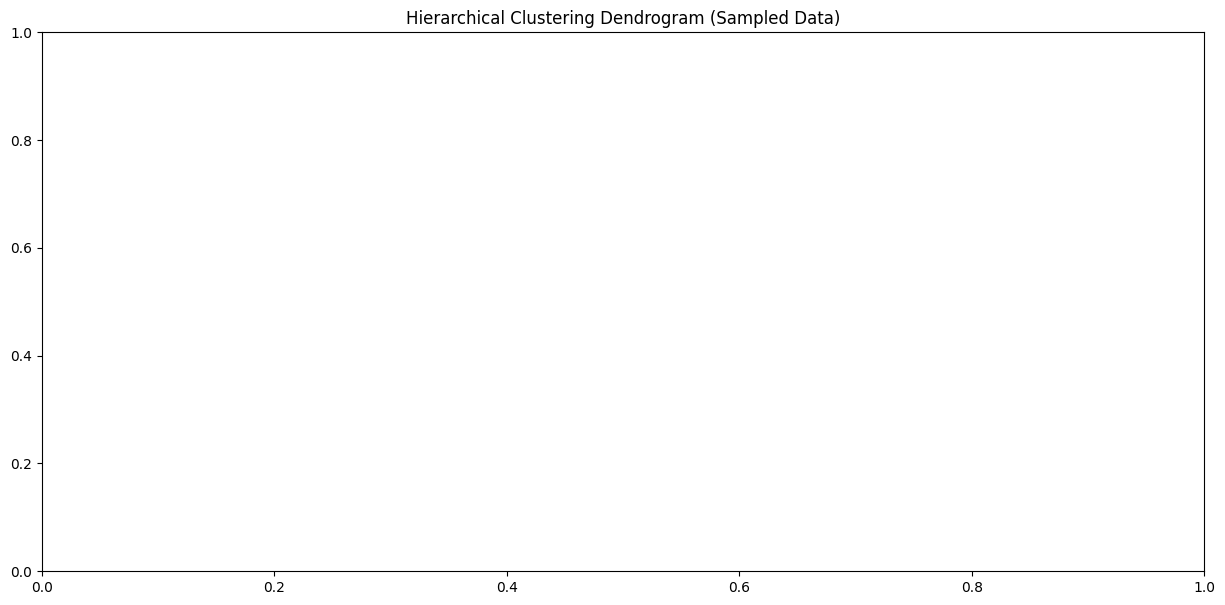

In [10]:
    # --- 8. Unsupervised Learning - Clustering ---
    print("\n--- 8. Unsupervised Learning - Clustering ---")

    # Sampling for Elbow Method & Hierarchical Clustering
    df_cluster_scaled_sample = df_cluster_scaled
    sampled_original_indices = original_indices_scaled

    if df_cluster_scaled.shape[0] > SAMPLE_SIZE * 1.5:
        print(f"\nSampling data down to {SAMPLE_SIZE} for efficiency...")
        np.random.seed(42)
        sample_indices = np.random.choice(df_cluster_scaled.shape[0], size=SAMPLE_SIZE, replace=False)
        df_cluster_scaled_sample = df_cluster_scaled[sample_indices, :]
        sampled_original_indices = original_indices_scaled[sample_indices]
        print(f"Sampled data shape: {df_cluster_scaled_sample.shape}")
    else:
        print("\nDataset size small enough, not sampling.")

    print(f"Using data of shape {df_cluster_scaled_sample.shape} for Elbow/Hierarchical.")

    # K-Means Clustering
    print("\nApplying K-Means Clustering...")
    print("Running Elbow Method (on sample)...")
    inertia = []
    k_range = range(2, 11)
    for k in k_range:
        try:
            kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
            kmeans.fit(df_cluster_scaled_sample)
            inertia.append(kmeans.inertia_)
            print(f"  Completed K={k}, Inertia={kmeans.inertia_:.2f}")
        except Exception as e:
            print(f"  Failed K={k}: {e}")
            inertia.append(None)

    # Plot Elbow Method
    valid_inertia = [(k, i) for k, i in zip(k_range, inertia) if i is not None]
    if valid_inertia:
        valid_k, valid_i = zip(*valid_inertia)
        plt.figure(figsize=(10, 5))
        plt.plot(valid_k, valid_i, marker='o')
        plt.title('Elbow Method for Optimal K (Sampled Data)')
        plt.xlabel('Number of Clusters (K)')
        plt.ylabel('Inertia')
        plt.xticks(valid_k)
        plt.grid(True)
        plt.savefig('kmeans_elbow_plot.png')
        plt.close()
        print("Saved Elbow Method plot as kmeans_elbow_plot.png")
        # Recommendation: Manually inspect kmeans_elbow_plot.png to potentially update OPTIMAL_K
        print(f"Recommendation: Inspect 'kmeans_elbow_plot.png' and potentially update OPTIMAL_K (currently {OPTIMAL_K}) in the script.")
    else:
        print("Could not generate Elbow plot.")

    # Apply K-Means with chosen K on FULL scaled data
    print(f"\nApplying K-Means with K={OPTIMAL_K} on full data...")
    # Note: K-Means on high-dimensional sparse data can lead to skewed clusters.
    kmeans_final = KMeans(n_clusters=OPTIMAL_K, init='k-means++', n_init=10, random_state=42)
    try:
        kmeans_labels = kmeans_final.fit_predict(df_cluster_scaled)
        df['KMeans_Cluster'] = pd.Series(kmeans_labels, index=original_indices_scaled)
        df['KMeans_Cluster'].fillna(-1, inplace=True)
        df['KMeans_Cluster'] = df['KMeans_Cluster'].astype(int)
        print(f"\nK-Means clustering complete. Cluster distribution:")
        print(df['KMeans_Cluster'].value_counts())
    except Exception as e:
        print(f"K-Means failed: {e}")
        df['KMeans_Cluster'] = -1


    # Hierarchical Clustering (on sample)
    print("\nApplying Hierarchical Clustering (on sample)...")
    # Note: Hierarchical clustering is computationally expensive (O(n^2) or O(n^3)).
    # Also, dendrogram plotting often requires dense matrices, which fail on large sparse data.
    try:
        plt.figure(figsize=(15, 7))
        plt.title("Hierarchical Clustering Dendrogram (Sampled Data)")
        # Linkage function can sometimes handle sparse input directly
        linked = shc.linkage(df_cluster_scaled_sample, method='ward')
        shc.dendrogram(linked, truncate_mode='lastp', p=12, leaf_rotation=90., leaf_font_size=8., show_contracted=True) # Truncate for readability
        plt.xlabel("Cluster Size (Sampled)")
        plt.ylabel("Distance")
        plt.savefig('hierarchical_dendrogram.png')
        plt.close()
        print("Saved Dendrogram plot as hierarchical_dendrogram.png")
    except MemoryError:
        print("MemoryError plotting dendrogram, sample might still be too large/dense.")
    except Exception as e:
        print(f"Could not generate Dendrogram: {e}") # May fail if linkage doesn't support sparse

    # Apply Agglomerative Clustering on sample
    N_CLUSTERS_HIERARCHICAL = OPTIMAL_K
    print(f"Applying Agglomerative Clustering with {N_CLUSTERS_HIERARCHICAL} clusters (on sample)...")
    try:
        agg_clustering = AgglomerativeClustering(n_clusters=N_CLUSTERS_HIERARCHICAL, linkage='ward')
        # AgglomerativeClustering might need dense array, try converting sample if feasible
        # Check memory footprint before converting to dense
        sample_elements = df_cluster_scaled_sample.shape[0] * df_cluster_scaled_sample.shape[1]
        # Estimate memory in GB (float64 is 8 bytes)
        estimated_memory_gb = sample_elements * 8 / (1024**3)
        print(f"Estimated memory for dense sample conversion: {estimated_memory_gb:.2f} GB")

        if estimated_memory_gb < 4: # Set a reasonable memory threshold (e.g., 4GB)
             print("Attempting Agglomerative Clustering on dense sample...")
             agg_labels_sample = agg_clustering.fit_predict(df_cluster_scaled_sample.toarray())
        else:
             print("Sample too large for dense conversion in AgglomerativeClustering, skipping fit.")
             agg_labels_sample = None

        if agg_labels_sample is not None:
            agg_cluster_series = pd.Series(agg_labels_sample, index=sampled_original_indices)
            df['Hierarchical_Cluster'] = agg_cluster_series
            df['Hierarchical_Cluster'].fillna(-1, inplace=True)
            df['Hierarchical_Cluster'] = df['Hierarchical_Cluster'].astype(int)
            print(f"\nHierarchical clustering complete. Cluster distribution (on sample):")
            print(df['Hierarchical_Cluster'].value_counts())
        else:
             df['Hierarchical_Cluster'] = -1

    except MemoryError:
        print("MemoryError during Agglomerative Clustering, sample might be too large for dense conversion.")
        df['Hierarchical_Cluster'] = -1
    except Exception as e:
        print(f"Hierarchical clustering failed: {e}")
        df['Hierarchical_Cluster'] = -1


In [11]:
# --- 9. Insights from Unsupervised Clustering ---
print("\n--- 9. Insights from Unsupervised Clustering ---")
print("\nAnalyzing K-Means Cluster Characteristics (Cluster Means):")
# Use only rows that were successfully clustered by K-Means
df_analysis = df.loc[df['KMeans_Cluster'] != -1].copy()

if not df_analysis.empty and df['KMeans_Cluster'].nunique() > 1:
    cluster_summary_num = df_analysis.groupby('KMeans_Cluster')[['ctc', 'Years_of_Experience']].mean()
    print("\nNumerical Feature Means per K-Means Cluster:")
    print(cluster_summary_num)

    print("\nCategorical Feature Distribution per K-Means Cluster (Top 5):")
    for cluster_id in sorted(df_analysis['KMeans_Cluster'].unique()):
        print(f"\n--- Cluster {cluster_id} ---")
        cluster_data = df_analysis[df_analysis['KMeans_Cluster'] == cluster_id]
        print(f"Size: {len(cluster_data)} learners")
        # Top Companies
        top_companies = cluster_data['Company_hash_Cleaned'].value_counts().head(5)
        print("Top 5 Companies:")
        print(top_companies)
        # Top Job Positions
        top_jobs = cluster_data['Job_position_Cleaned'].value_counts().head(5)
        print("\nTop 5 Job Positions:")
        print(top_jobs)
    # Add comment about potential skewness observed in output
    print("\n*Note: K-Means cluster sizes appear highly skewed. One cluster dominates, others are small.")
    print(" This might indicate outliers or limitations of K-Means on this high-dimensional sparse data.")
    print(" Further analysis might involve different feature scaling, feature selection, or algorithms (e.g., DBSCAN).")

else:
    print("No K-Means clusters found or K-Means failed/produced only one cluster.")


--- 9. Insights from Unsupervised Clustering ---

Analyzing K-Means Cluster Characteristics (Cluster Means):

Numerical Feature Means per K-Means Cluster:
                         ctc  Years_of_Experience
KMeans_Cluster                                   
0               2.271916e+06             9.883611
1               1.800000e+06             7.000000
2               3.600000e+05             6.000000
3               6.700000e+05            11.000000
4               1.060000e+06            16.333333

Categorical Feature Distribution per K-Means Cluster (Top 5):

--- Cluster 0 ---
Size: 205801 learners
Top 5 Companies:
Company_hash_Cleaned
nvnv wgzohrnvzwj otqcxwto    8337
xzegojo                      5381
vbvkgz                       3481
zgn vuurxwvmrt vwwghzn       3410
wgszxkvzn                    3240
Name: count, dtype: int64

Top 5 Job Positions:
Job_position_Cleaned
unknown_position      52548
backend engineer      43544
fullstack engineer    25976
other                 18070
f

In [12]:
# --- 10. Save Output & Recommendations ---
output_file = 'scaler_clustered_data.csv'
print(f"\n--- 10. Saving processed data to {output_file}... ---")
try:
    # Ensure float columns don't have excessive precision causing large file sizes
    float_cols = df.select_dtypes(include=['float']).columns
    for col in float_cols:
        df[col] = df[col].round(4) # Round floats to reasonable precision
    df.to_csv(output_file, index=False)
    print("File saved successfully.")
except Exception as e:
    print(f"Error saving file: {e}")

print("\n--- Actionable Insights & Recommendations ---")
# Recommendations remain largely the same structure, but interpretation depends on actual cluster results
print(f"""
Based on the analysis (interpret actual results from the run):

**Insights:**

1.  **Learner Segmentation:** K-Means clustering (K={OPTIMAL_K}) was performed, but resulted in highly unbalanced clusters (check console output/CSV). One cluster likely contains the vast majority of learners, while others capture outliers or very small groups. This limits the usefulness of these specific K-Means clusters for broad segmentation. Manual flags provide more practical segmentation for now.
2.  **Manual vs. Unsupervised:** The manual flags (Tier, Class, Designation) provide valuable insights into relative compensation within specific peer groups (Company, Job, Experience). These are likely more reliable for targeted actions than the current K-Means results. Compare flags and K-Means labels in `scaler_clustered_data.csv`.
3.  **Company/Role Attractiveness:** Top companies and roles were identified based on average CTC (filtered for minimum group size). Review the console output for these rankings. Be mindful of potential CTC outliers influencing averages.
4.  **Experience-ctc Correlation:** A positive correlation generally exists (see `bivariate_exp_ctc.png`), though log-scaling was needed for visualization due to CTC skewness. Manual flags help understand variations within specific experience levels.
5.  **Data Quality:** Issues noted include invalid `orgyear` values (handled by capping experience) and potential extreme outliers in `ctc`, which impact analysis.

**Recommendations for Scaler:**

1.  **Leverage Manual Flags:** Use the Tier, Class, and Designation flags for targeted career services, salary benchmarking, and identifying upskilling opportunities, as the unsupervised clusters were not well-balanced.
2.  **Curriculum Enhancement:** Analyze job roles associated with Tier 1 / Class 1 employees and ensure curriculum alignment.
3.  **Employer Partnerships:** Focus on companies identified as 'top employers' (considering average CTC and employee count).
4.  **Future Analysis:**
    *   Investigate and clean/handle CTC outliers more formally (e.g., capping, log transform *before* clustering).
    *   Explore alternative clustering algorithms suitable for high-dimensional sparse data (e.g., DBSCAN, Birch) or dimensionality reduction techniques (e.g., PCA, TruncatedSVD) before clustering.
    *   Refine feature engineering/selection for unsupervised clustering.
    *   Manually inspect the elbow plot (`kmeans_elbow_plot.png`) to confirm if K={OPTIMAL_K} is appropriate or if a different K should be chosen.

""")

print("\n--- Analysis Complete ---")


--- 10. Saving processed data to scaler_clustered_data.csv... ---
File saved successfully.

--- Actionable Insights & Recommendations ---

Based on the analysis (interpret actual results from the run):

**Insights:**

1.  **Learner Segmentation:** K-Means clustering (K=5) was performed, but resulted in highly unbalanced clusters (check console output/CSV). One cluster likely contains the vast majority of learners, while others capture outliers or very small groups. This limits the usefulness of these specific K-Means clusters for broad segmentation. Manual flags provide more practical segmentation for now.
2.  **Manual vs. Unsupervised:** The manual flags (Tier, Class, Designation) provide valuable insights into relative compensation within specific peer groups (Company, Job, Experience). These are likely more reliable for targeted actions than the current K-Means results. Compare flags and K-Means labels in `scaler_clustered_data.csv`.
3.  **Company/Role Attractiveness:** Top compani